In [1]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt
import xlrd
import tensorflow.keras.backend as K
import pandas as pd
import requests
# import nvidia_smi

from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.python.client import device_lib


# Changing directories to access the dataset
d = os.getcwd()
if d != '/home/ec2-user/SageMaker/Semantic_Segmentation' :
    os.chdir("..")
from labels import *

In [2]:
labelID = {}
rgbColorID = {}

for i,label in enumerate(labels):
    labelID[i] = label.name
    rgbColorID[i] = label.color

print(labelID)
print(rgbColorID)

{0: 'unlabeled', 1: 'dynamic', 2: 'ground', 3: 'road', 4: 'sidewalk', 5: 'parking', 6: 'rail track', 7: 'building', 8: 'wall', 9: 'fence', 10: 'guard rail', 11: 'bridge', 12: 'tunnel', 13: 'pole', 14: 'traffic light', 15: 'traffic sign', 16: 'vegetation', 17: 'terrain', 18: 'sky', 19: 'person', 20: 'rider', 21: 'car', 22: 'truck', 23: 'bus', 24: 'caravan', 25: 'trailer', 26: 'train', 27: 'motorcycle', 28: 'bicycle'}
{0: (0, 0, 0), 1: (111, 74, 0), 2: (81, 0, 81), 3: (128, 64, 128), 4: (244, 35, 232), 5: (250, 170, 160), 6: (230, 150, 140), 7: (70, 70, 70), 8: (102, 102, 156), 9: (190, 153, 153), 10: (180, 165, 180), 11: (150, 100, 100), 12: (150, 120, 90), 13: (153, 153, 153), 14: (250, 170, 30), 15: (220, 220, 0), 16: (107, 142, 35), 17: (152, 251, 152), 18: (70, 130, 180), 19: (220, 20, 60), 20: (255, 0, 0), 21: (0, 0, 142), 22: (0, 0, 70), 23: (0, 60, 100), 24: (0, 0, 90), 25: (0, 0, 110), 26: (0, 80, 100), 27: (0, 0, 230), 28: (119, 11, 32)}


In [3]:
def rgb_to_onehot(rgb_image, colormap):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    index = 0
    for i, cls in enumerate(colormap):
        encoded_image[:,:,index] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        index += 1
        
    return encoded_image

In [4]:
# Input Image Dimensions
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
numClasses = 29
batchSize = 16
learningRate = 0.001
numOfEpoch = 100

In [5]:
def My_Generator(image_filenames, labels, batch_size):
    idx = 0
    batch_x = image_filenames[idx * batch_size:(idx + 1) * batch_size]
    batch_y = labels[idx * batch_size:(idx + 1) * batch_size]

    X_train = []
    Y_train = []

    for i in tqdm(range(len(batch_x))):
        response = requests.get(batch_x[i])
        train = np.asarray(Image.open(BytesIO(response.content)))
        train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        X_train.append(train)

    for i in tqdm(range(len(batch_y))):
        response = requests.get(batch_y[i])
        img1 = np.asarray(Image.open(BytesIO(response.content)).convert('RGB'))
#             imgCopy = np.zeros(img1.shape, dtype = 'uint8')
#             for i,cls in enumerate(rgbColorID):
#                 if i in otherClassIndices:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[0]
#                 else:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[i]
        Mask = cv2.resize(img1, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
#         Mask = rgb_to_onehot(Mask, rgbColorID)
        Y_train.append(Mask)

    np.savez_compressed('Val29', image = np.array(X_train, dtype='uint8'),
                                   label = np.array(Y_train, dtype='uint8'))
    
    return 100

In [6]:
parameter = False
if parameter:
    temp = My_Generator(validationImagesNames, validationMasksNames,len(validationImagesNames))

In [7]:
# Building the Resnet model
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT, IMG_CHANNELS)) # Defining the input layer
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # Converting input pixels to floating values

c1 = tf.keras.layers.Conv2D(64, (7,7), strides=2,kernel_initializer='he_normal', padding='same')(s)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
res1 = tf.keras.layers.MaxPooling2D(3, 2, padding='same')(r1) #-------------------------------------------------------
#                                                                                                                     |
c2 = tf.keras.layers.Conv2D(64, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res1)#               |
b2 = tf.keras.layers.BatchNormalization()(c2)#                                                                        |
r2 = tf.keras.layers.ReLU()(b2)#                                                                                      |
#                                                                                                                     |
c3 = tf.keras.layers.Conv2D(64, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r2)#                 |
b3 = tf.keras.layers.BatchNormalization()(c3)#                                                                        |
a3 = tf.keras.layers.Add()([b3, res1])# <--------------------------------------------------------------------------------
res2 = tf.keras.layers.ReLU()(a3) #------------------------------------------------------------------------------------
#                                                                                                                     |
c4 = tf.keras.layers.Conv2D(64, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res2)#               |
b4 = tf.keras.layers.BatchNormalization()(c4)#                                                                        |
r4 = tf.keras.layers.ReLU()(b4)#                                                                                      |
#                                                                                                                     |
c4 = tf.keras.layers.Conv2D(64, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r4)#                 |
b4 = tf.keras.layers.BatchNormalization()(c4)#                                                                        |
a4 = tf.keras.layers.Add()([b4, res2])# <--------------------------------------------------------------------------------
res3 = tf.keras.layers.ReLU()(a4) #------------------------------------------------------------------------------------
#                                                                                                                     |
c5 = tf.keras.layers.Conv2D(64, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res3)#               |
b5 = tf.keras.layers.BatchNormalization()(c5)#                                                                        |
r5 = tf.keras.layers.ReLU()(b5)#                                                                                      |
#                                                                                                                     |
c6 = tf.keras.layers.Conv2D(64, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r5)#                 |
b6 = tf.keras.layers.BatchNormalization()(c6)#                                                                        |
a6 = tf.keras.layers.Add()([b6, res3])# <-----------------------------------------------------------------------------
r6 = tf.keras.layers.ReLU()(a6) 
#                                                                                                                     
c11 = tf.keras.layers.Conv2D(128, (1,1), strides=2,kernel_initializer='he_normal', padding='same')(r6)# 
res4 = tf.keras.layers.BatchNormalization()(c11)#-----------------------------------------------------------------------                                                                                     |
#                                                                                                                     |
c12 = tf.keras.layers.Conv2D(128, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res4)#             |
b12 = tf.keras.layers.BatchNormalization()(c12)#                                                                      |
r12 = tf.keras.layers.ReLU()(b12) #                                                                                   |
#                                                                                                                     |
c13 = tf.keras.layers.Conv2D(128, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r12)#              |
b13 = tf.keras.layers.BatchNormalization()(c13)#                                                                      |
a13 = tf.keras.layers.Add()([b13, res4])#<-----------------------------------------------------------------------------
res5 = tf.keras.layers.ReLU()(a13)#------------------------------------------------------------------------------------
#                                                                                                                     |
c14 = tf.keras.layers.Conv2D(128, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res5)#             |
b14 = tf.keras.layers.BatchNormalization()(c14)#                                                                      |
r14 = tf.keras.layers.ReLU()(b14) #                                                                                   |
#                                                                                                                     |
c15 = tf.keras.layers.Conv2D(128, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r14)#              |
b15 = tf.keras.layers.BatchNormalization()(c15)#                                                                      |
a15 = tf.keras.layers.Add()([b15, res5])#<----------------------------------------------------------------------------
res6 = tf.keras.layers.ReLU()(a15)#------------------------------------------------------------------------------------
#                                                                                                                     |
c16 = tf.keras.layers.Conv2D(128, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res6)#             |
b16 = tf.keras.layers.BatchNormalization()(c16)#                                                                      |
r16 = tf.keras.layers.ReLU()(b16) #                                                                                   |
#                                                                                                                     |
c17 = tf.keras.layers.Conv2D(128, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r16)#              |
b17 = tf.keras.layers.BatchNormalization()(c17)#                                                                      |
a17 = tf.keras.layers.Add()([b17, res6])#<----------------------------------------------------------------------------
r17 = tf.keras.layers.ReLU()(a17)#

c21 = tf.keras.layers.Conv2D(256, (1,1), strides=2,kernel_initializer='he_normal', padding='same')(r17)# 
res7 = tf.keras.layers.BatchNormalization()(c21)#-----------------------------------------------------------------------                                                                                     |
#                                                                                                                     |
c22 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res7)#             |
b22 = tf.keras.layers.BatchNormalization()(c22)#                                                                      |
r22 = tf.keras.layers.ReLU()(b22) #                                                                                   |
#                                                                                                                     |
c23 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r22)#              |
b23 = tf.keras.layers.BatchNormalization()(c23)#                                                                      |
a23 = tf.keras.layers.Add()([b23, res7])#<-----------------------------------------------------------------------------
res8 = tf.keras.layers.ReLU()(a23)#------------------------------------------------------------------------------------
#                                                                                                                     |
c24 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res8)#             |
b24 = tf.keras.layers.BatchNormalization()(c24)#                                                                      |
r24 = tf.keras.layers.ReLU()(b24) #                                                                                   |
#                                                                                                                     |
c25 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r24)#              |
b25 = tf.keras.layers.BatchNormalization()(c25)#                                                                      |
a25 = tf.keras.layers.Add()([b25, res8])#<----------------------------------------------------------------------------
res9 = tf.keras.layers.ReLU()(a25)#------------------------------------------------------------------------------------
#                                                                                                                     |
c26 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res9)#             |
b26 = tf.keras.layers.BatchNormalization()(c26)#                                                                      |
r26 = tf.keras.layers.ReLU()(b26) #                                                                                   |
#                                                                                                                     |
c27 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r26)#              |
b27 = tf.keras.layers.BatchNormalization()(c27)#                                                                      |
a27 = tf.keras.layers.Add()([b27, res9])#<----------------------------------------------------------------------------
res10 = tf.keras.layers.ReLU()(a27)#------------------------------------------------------------------------------------
#                                                                                                                     |
c28 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res10)#              |
b28 = tf.keras.layers.BatchNormalization()(c28)#                                                                      |
r28 = tf.keras.layers.ReLU()(b28) #                                                                                   |
#                                                                                                                     |
c29 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r28)#              |
b29 = tf.keras.layers.BatchNormalization()(c29)#                                                                      |
a29 = tf.keras.layers.Add()([b29, res10])#<----------------------------------------------------------------------------
r29 = tf.keras.layers.ReLU()(a29)#------------------------------------------------------------------------------------
#                                                                                                                     |
c26 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r29)#              |
b26 = tf.keras.layers.BatchNormalization()(c26)#                                                                      |
r26 = tf.keras.layers.ReLU()(b26) #                                                                                   |
#                                                                                                                     |
c27 = tf.keras.layers.Conv2D(256, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r26)#              |
b27 = tf.keras.layers.BatchNormalization()(c27)#                                                                      |
a27 = tf.keras.layers.Add()([b27, r29])#<----------------------------------------------------------------------------
r27 = tf.keras.layers.ReLU()(a27)#

c31 = tf.keras.layers.Conv2D(512, (1,1), strides=2,kernel_initializer='he_normal', padding='same')(r27)# 
res10 = tf.keras.layers.BatchNormalization()(c31)#-----------------------------------------------------------------------                                                                                     
#                                                                                                                     |
c32 = tf.keras.layers.Conv2D(512, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res10)#            |
b32 = tf.keras.layers.BatchNormalization()(c32)#                                                                      |
r32 = tf.keras.layers.ReLU()(b32) #                                                                                   |
#                                                                                                                     |
c33 = tf.keras.layers.Conv2D(512, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r32)#              |
b33 = tf.keras.layers.BatchNormalization()(c33)#                                                                      |
a33 = tf.keras.layers.Add()([b33, res10])#<----------------------------------------------------------------------------
res11 = tf.keras.layers.ReLU()(a33)#------------------------------------------------------------------------------------
#                                                                                                                     |
c34 = tf.keras.layers.Conv2D(512, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(res11)#            |
b34 = tf.keras.layers.BatchNormalization()(c34)#                                                                      |
r34 = tf.keras.layers.ReLU()(b34) #                                                                                   |
#                                                                                                                     |
c35 = tf.keras.layers.Conv2D(512, (3,3), strides=1,kernel_initializer='he_normal', padding='same')(r34)#              |
b35 = tf.keras.layers.BatchNormalization()(c35)#                                                                      |
a35 = tf.keras.layers.Add()([b35, res11])#<----------------------------------------------------------------------------
r12 = tf.keras.layers.ReLU()(a35)

# out = tf.keras.layers.GlobalAveragePooling2D()(r12)
u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(r12)
u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(u10)
u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(u10)
u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(u10)
u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(u10)
output = tf.keras.layers.Conv2D(numClasses, (1,1), activation='sigmoid', padding='same')(u10)

model = tf.keras.Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=numClasses),
                                                                          tf.keras.metrics.Precision(),
                                                                          tf.keras.metrics.Recall(),
                                                                          'accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [8]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_multiclass.h5',
                                                  verbose=2,
                                                  save_best_only=True,
                                                  monitor='loss',
                                                  mode='min')

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=1,
                                              monitor='loss',
                                              mode='min'),
             tf.keras.callbacks.TensorBoard(log_dir='logs',
                                            write_graph=True)]

In [9]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/Train29.npz')
train = np.load(BytesIO(response.content))

In [10]:
results = model.fit(train['image'], train['label'], validation_split=0.3, batch_size = batchSize,callbacks=callbacks, verbose = 1,epochs = numOfEpoch)

Train on 2082 samples, validate on 893 samples
Epoch 1/100
2082/2082 [==============================] - 106s 51ms/sample - loss: 1.6360 - mean_io_u: 0.5171 - precision: 0.1969 - recall: 0.8186 - accuracy: 0.3149 - val_loss: 6.5296 - val_mean_io_u: 0.5512 - val_precision: 0.2084 - val_recall: 0.4349 - val_accuracy: 0.2132
Epoch 2/100
2082/2082 [==============================] - 97s 47ms/sample - loss: 1.2038 - mean_io_u: 0.4959 - precision: 0.3921 - recall: 0.8132 - accuracy: 0.3611 - val_loss: 1.2333 - val_mean_io_u: 0.4874 - val_precision: 0.4805 - val_recall: 0.6622 - val_accuracy: 0.5520
Epoch 3/100
2082/2082 [==============================] - 93s 45ms/sample - loss: 0.8983 - mean_io_u: 0.4838 - precision: 0.5282 - recall: 0.6135 - accuracy: 0.6051 - val_loss: 0.9288 - val_mean_io_u: 0.4840 - val_precision: 0.4929 - val_recall: 0.5829 - val_accuracy: 0.6747
Epoch 4/100
2082/2082 [==============================] - 92s 44ms/sample - loss: 0.7832 - mean_io_u: 0.4839 - precision: 0.6240

In [11]:
train = []

In [12]:
model.save('models/Resnet-S256-C29-B16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/Resnet-S256-C29-B16/assets


In [13]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/Val29.npz')
test = np.load(BytesIO(response.content))
X_test = test['image']
Y_test = test['label']

In [14]:
model = tf.keras.models.load_model('models/Resnet-S256-C29-B16')

In [15]:
preds_val = model.predict(X_test, verbose=1)

500/500 [==============================] - 11s 22ms/sample


In [16]:
def onehot_to_rgb(onehot, colormap):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [31]:
preds_valRGB = []
for i in range(len(X_test)):
    preds_valRGB.append(onehot_to_rgb(preds_val[i], rgbColorID))

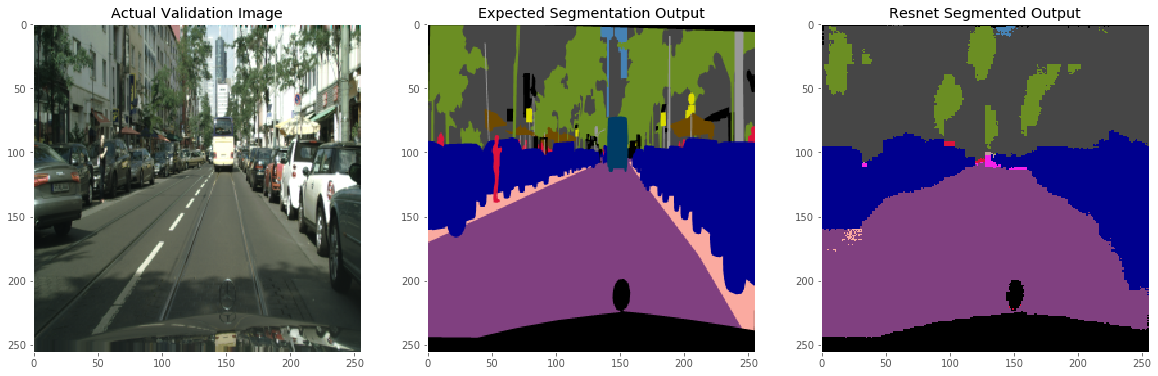

In [32]:
# Comparing the results

ix = random.randint(0, len(preds_valRGB))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Validation Image')
ax1.grid(False)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Resnet Segmented Output')
ax3.imshow(preds_valRGB[ix])
ax3.grid(False)

In [22]:
iou = []
classesPresent = ['Absent']*numClasses
s = np.zeros(numClasses)
p = np.zeros(numClasses)
for j in tqdm(range(len(X_test))):
    temp = rgb_to_onehot(Y_test[j], rgbColorID)
    for i in range(numClasses):
        if np.any(temp[:,:,i]) == 1:
            classesPresent[i] = 'Present'
            p[i] += 1
        intersection = np.logical_and(temp[:,:,i], preds_val[j][:,:,i])
        union = np.logical_or(temp[:,:,i], preds_val[j][:,:,i])
        s[i] += np.sum(intersection) / np.sum(union)
        


for i in range(numClasses):
    if p[i] == 0:
        iou.append(str(0)+"%")
    else:
        iou.append(str(round((s[i]*100)/p[i], 3)) + '%')

labels = []
for i in range(numClasses):
    labels.append(labelID[i])
    
classes = {'labels': labels,
        'IOU Accuracy': iou,
        'Classes Encountered' : classesPresent
        }

df = pd.DataFrame(classes, columns = ['labels','IOU Accuracy', 'Classes Encountered'])

print (df)


           labels IOU Accuracy Classes Encountered
0       unlabeled       8.681%             Present
1         dynamic       0.687%             Present
2          ground       4.698%             Present
3            road      33.421%             Present
4        sidewalk       4.639%             Present
5         parking       1.655%             Present
6      rail track       2.039%             Present
7        building       18.21%             Present
8            wall       1.455%             Present
9           fence       1.725%             Present
10     guard rail       1.647%             Present
11         bridge       0.894%             Present
12         tunnel           0%              Absent
13           pole       0.618%             Present
14  traffic light       0.234%             Present
15   traffic sign       0.483%             Present
16     vegetation      14.471%             Present
17        terrain       1.389%             Present
18            sky       3.073%

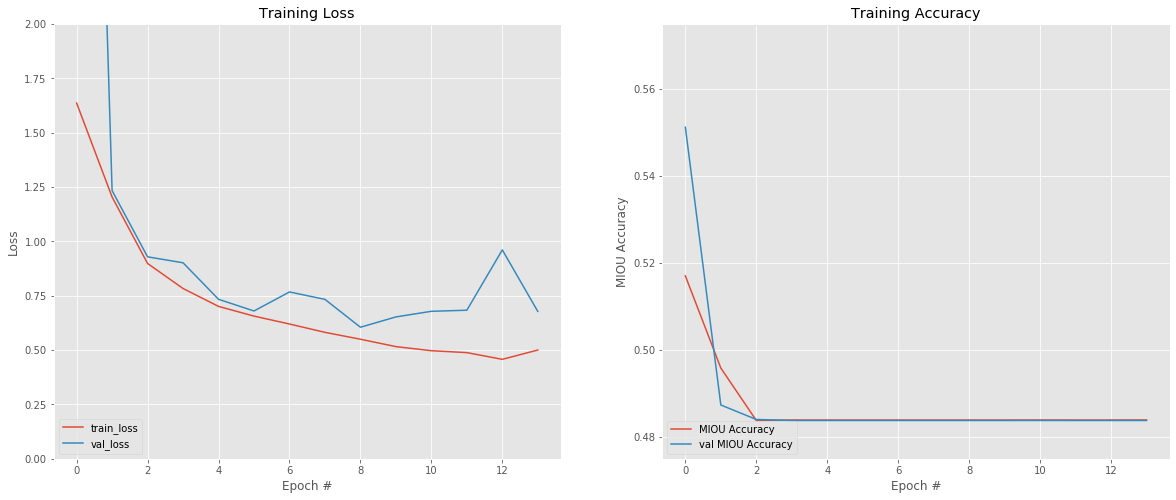

In [26]:
N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 2)

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["mean_io_u"], label="MIOU Accuracy")
plt.plot(np.arange(0, N), results.history["val_mean_io_u"], label="val MIOU Accuracy")
plt.ylim(0.475, 0.575)

plt.xlabel("Epoch #")
plt.ylabel("MIOU Accuracy")
plt.legend(loc="lower left")
plt.show()

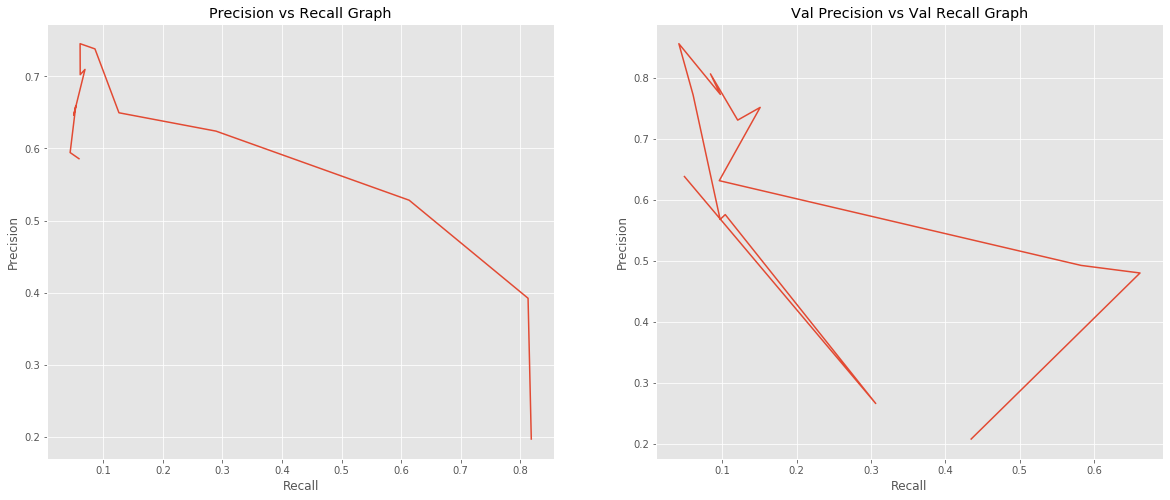

In [27]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.plot(results.history['recall'], results.history['precision']) 
# naming the x axis 
plt.xlabel('Recall') 
# naming the y axis 
plt.ylabel('Precision') 
  
# giving a title to my graph 
plt.title('Precision vs Recall Graph') 
  
    
fig.add_subplot(1,2,2)
plt.plot(results.history['val_recall'], results.history['val_precision']) 
# naming the x axis 
plt.xlabel('Recall') 
# naming the y axis 
plt.ylabel('Precision') 
  
# giving a title to my graph 
plt.title('Val Precision vs Val Recall Graph') 
    
# function to show the plot 
plt.show() 